In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics

import dask
import timeit
import intake

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
# from dask.distributed import Client
# client = Client(n_workers=8, )
# client
dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler

In [3]:
metrics_all = ['mean_25km_1km']
runType = 'forecast'
variables = ['hi']

In [4]:
# Get path data
%env DATA_DIR=/home/jovyan/projects/esio/data

E = ed.EsioData.load()
grid_dir = E.grid_dir

env: DATA_DIR=/home/jovyan/projects/esio/data


In [5]:
# File listing data in catalog
catalog_url = 'https://raw.githubusercontent.com/NicWayand/example.pangeo.io-deploy/staging/deployments/polar.pangeo.io/image/catalog.yaml'

In [6]:
# Load in regional masks
ds_regional = intake.Catalog(catalog_url).SIPN2_GRIDS.to_dask().load()

In [7]:
concat_dim_time = 'fore_time'
drop_coords = ['init_start','valid_start','valid_end']

In [8]:
cvar = variables[0]

In [9]:
# Define fig dir and make if doesn't exist (Hard coded here)
fig_dir = os.path.join(os.getcwd(),'figures')

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [10]:
# Load SIT data from Zarr
ds_m = intake.Catalog(catalog_url).SIPN2_SIT.to_dask()

In [11]:
ds_ALL = import_data.get_valid_time(ds=ds_m, init_dim='init_end')

In [12]:
ds_ALL

<xarray.Dataset>
Dimensions:        (fore_time: 72, init_end: 56, model: 6, x: 304, y: 448)
Coordinates:
  * fore_time      (fore_time) timedelta64[ns] 0 days 1 days 2 days 3 days ...
  * init_end       (init_end) datetime64[ns] 2018-02-01 2018-02-06 ...
    lat            (x, y) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
    lon            (x, y) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
  * model          (model) object 'Observed' 'gfdlsipn' 'rasmesrl' ...
    valid_time     (init_end, fore_time) datetime64[ns] 2018-02-01 ...
Dimensions without coordinates: x, y
Data variables:
    mean_25km_1km  (init_end, model, fore_time, x, y) float64 dask.array<shape=(56, 6, 72, 304, 448), chunksize=(8, 1, 8, 304, 448)>

In [13]:
ds_ALL.model

<xarray.DataArray 'model' (model: 6)>
array(['Observed', 'gfdlsipn', 'rasmesrl', 'usnavygofs', 'usnavyncep', 'MME'],
      dtype=object)
Coordinates:
  * model    (model) object 'Observed' 'gfdlsipn' 'rasmesrl' 'usnavygofs' ...

In [15]:
def add_subplot_title(cmod, E, ax=None, statval=None):
    if cmod in E.model.keys():
        if statval:
            ax.set_title(E.model[cmod]['model_label']+'\n('+statval+')')
        else:
            ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

In [16]:
max_hi = 4

In [17]:
import scipy

In [18]:
def get_pearsonr(x,y):
    I_ok = (~np.isnan(x)) & (~np.isnan(y))
    x = x[I_ok]
    y = y[I_ok]
    
    (r,p) = scipy.stats.pearsonr(x,y)
    return r

In [19]:
def get_rmse(x,y):
    I_ok = (~np.isnan(x)) & (~np.isnan(y))
    x = x[I_ok]
    y = y[I_ok]
    
    rmse = np.sqrt(np.mean((x-y)**2))
    return rmse

$r^2$=0.024, rmse=1.44
$r^2$=0.469, rmse=0.61
$r^2$=0.007, rmse=1.29
$r^2$=0.008, rmse=1.30
$r^2$=0.031, rmse=1.22


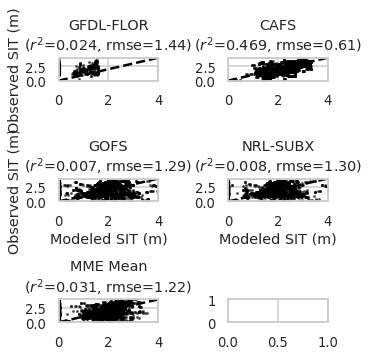

In [20]:
## Plot multi-panel scatter model vs obs
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})
mod_stats_dic = {}

ncols = 2
nrows = 3
f, (axes) = plt.subplots(ncols=ncols, nrows=nrows)
f.set_size_inches((5,5))
axes = axes.reshape(-1)
cx = 0
for cmod in ds_ALL.model.values:
    if (cmod=='Observed'):
        continue
    cmod_values = ds_ALL.isel(fore_time=slice(0,6)).sel(model=cmod).mean_25km_1km.values.flatten()
    cobs_values = ds_ALL.isel(fore_time=slice(0,6)).sel(model='Observed').mean_25km_1km.values.flatten()
    
    axes[cx].scatter(cmod_values,
                     cobs_values, 
                     c='k', 
                     marker='.',
                     s=10,
                     alpha=0.5)
    r = get_pearsonr(cmod_values, cobs_values)
    rmse = get_rmse(cmod_values, cobs_values)
    stat_str = '$r^2$={0:.3f}, '.format(r**2) + 'rmse={0:.2f}'.format(rmse)
    mod_stats_dic[cmod] = stat_str
    print(stat_str)
    axes[cx].plot([0,max_hi],[0,max_hi],'k--')
    add_subplot_title(cmod, E, ax=axes[cx], statval=stat_str)
    axes[cx].set_ylim([0,max_hi])
    axes[cx].set_xlim([0,max_hi])
    max_hi
    if cx in [0,2]:
        axes[cx].set_ylabel('Observed SIT (m)')
    if cx in [2,3]:
        axes[cx].set_xlabel('Modeled SIT (m)')
    
    cx = cx + 1
plt.tight_layout()

In [21]:
def add_subplot_title(cmod, E, ax=None, statval=None, fontsize=24, fontcolor='k'):
    if cmod in E.model.keys():
        if statval:
            ax.set_title(E.model[cmod]['model_label']+'\n('+statval+')', fontsize=24, color=fontcolor)
        else:
            ax.set_title(E.model[cmod]['model_label'], fontsize=24, color=fontcolor)
    else:
        ax.set_title(cmod)

In [22]:
# Trying new map plot, colored overlays and scatter plot

In [23]:
ds_ALL.model.values

array(['Observed', 'gfdlsipn', 'rasmesrl', 'usnavygofs', 'usnavyncep',
       'MME'], dtype=object)

In [24]:
mod_stats_dic['Observed'] = None
mod_colors = {'Observed':'k', 'gfdlsipn':'r', 'rasmesrl':'b', 
              'usnavygofs':'k', 'usnavyncep':'m','MME':'grey'}

/srv/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/lib/python3.6/site-packages/dask/array/numpy_compat.p

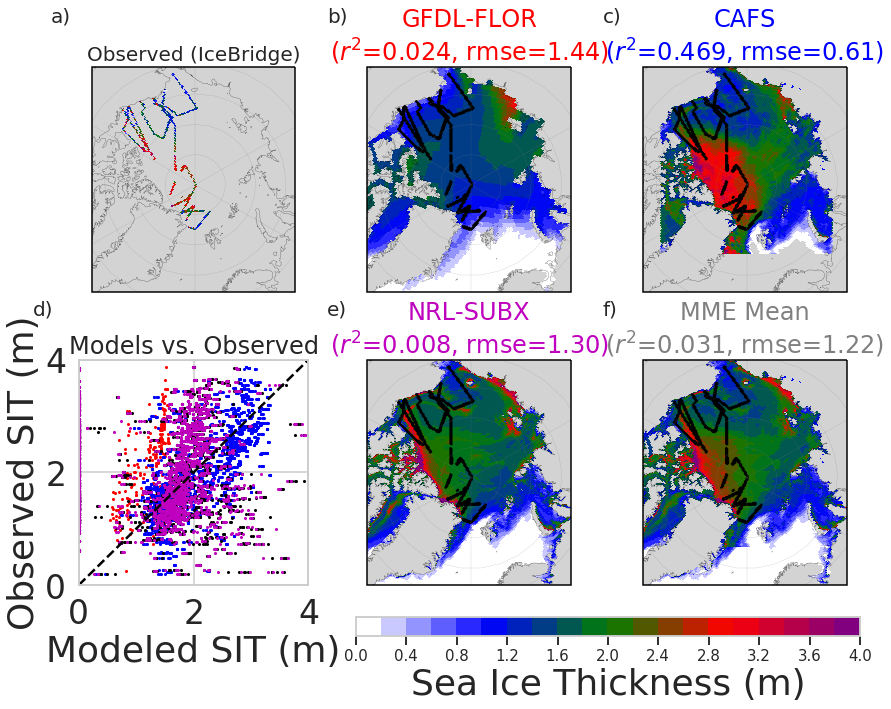

In [25]:
## Plot subplots of SIT, model with observed overlayed
# Set up color maps
sns.set_context("talk", font_scale=2, rc={"lines.linewidth": 2.5})

N_cmap = 20
cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","blue","green","red","purple"], N=N_cmap)
#cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues", N_cmap))

cmap_c.set_bad(color = 'lightgrey')
c_label = 'Sea Ice Thickness (m)'
c_vmin = 0
c_vmax = 4

cmap_b = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","black"], N=2)


nrows = 2#np.int(np.ceil(np.sqrt(ds_ALL.model.size)))
ncols = 3#nrows
Nplots = ds_ALL.model.size + 1

ft_start = 0
ft_end = 6 # inclusive!


# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=ncols, nrows=nrows, Nplots=Nplots, 
                                      extent=central_extent, central_longitude=0)

f.set_size_inches(14, 9)

label_dict = {0:'a)',1:'b)',2:'c)',4:'e)',5:'f)',}

for (i, cmod) in enumerate(ds_ALL.model.values): #['Observed']+dynamical_Models+['MME']):
    # Plot
    
    if cmod=='usnavygofs':
        axs = plt.subplot(2,3,4)

        axs.set_title('Models vs. Observed', fontsize=24)
        
        axs.text(-0.2, 1.2,'d)', fontsize=20, transform = axs.transAxes)
        
        for cmod in ds_ALL.model.values:
            if (cmod=='Observed') | (cmod=='MME'):
                continue
            cmod_values = ds_ALL.isel(fore_time=slice(ft_start,ft_end)).sel(model=cmod).mean_25km_1km.values.flatten()
            cobs_values = ds_ALL.isel(fore_time=slice(ft_start,ft_end)).sel(model='Observed').mean_25km_1km.values.flatten()

            axs.scatter(cmod_values,
                             cobs_values, 
                             c = mod_colors[cmod],
                             marker='.',
                             s=10,
                             alpha=1)
#             r = get_pearsonr(cmod_values, cobs_values)
#             rmse = get_rmse(cmod_values, cobs_values)
#             stat_str = '$r^2$={0:.3f}, '.format(r**2) + 'rmse={0:.2f}'.format(rmse)

            
        axs.plot([0,max_hi],[0,max_hi],'k--')
        #add_subplot_title(cmod, E, ax=axes[cx], statval=stat_str)
    #     axes[cx].set_title(cmod)
        axs.set_ylim([0,max_hi])
        axs.set_xlim([0,max_hi])
        axs.set_ylabel('Observed SIT (m)')
        axs.set_xlabel('Modeled SIT (m)')
        
        
    else:
        add_subplot_title(cmod, E, ax=axes[i], fontsize=20, statval=mod_stats_dic[cmod], fontcolor=mod_colors[cmod])
        p = ds_ALL.sel(model=cmod).isel(fore_time=slice(ft_start,ft_end)).mean(dim=['init_end','fore_time']).mean_25km_1km.plot.pcolormesh(ax=axes[i], 
                                x='lon', y='lat', 
                                transform=ccrs.PlateCarree(),
                                add_colorbar=False,cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
        if cmod!='Observed':
            axes[i].scatter(ds_ALL.lon.values,
                           ds_ALL.lat.values,
                           c = ds_ALL.sel(model='Observed').isel(fore_time=slice(ft_start,ft_end)).mean(dim=['init_end','fore_time']).mean_25km_1km.values,
                           s = 1,
                           transform=ccrs.PlateCarree(),
                           cmap=cmap_b,vmin=c_vmin, vmax=c_vmax)
        add_subplot_title(cmod, E, ax=axes[i], fontsize=24, statval=mod_stats_dic[cmod], fontcolor=mod_colors[cmod])
        if cmod=='Observed':
             axes[i].set_title('Observed (IceBridge)', fontsize=20) 
                
        axes[i].text(-0.2, 1.2, label_dict[i], fontsize=20, transform = axes[i].transAxes)

# Make pretty
f.subplots_adjust(bottom=0.08, hspace=0.3)
# cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cbar_ax = f.add_axes([0.4, 0.001, .5, 0.03]) #  [left, bottom, width, height] w
cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(np.arange(0,max_hi+0.1,max_hi/N_cmap*2))
cbar.ax.tick_params(labelsize=15) 
cbar.ax.yaxis.label.set_size(20)

# # Save to file
f_out = os.path.join(fig_dir,'SIT_maps_all_NEW_init_day_'+str(ft_start)+'_to_'+str(ft_end)+'_ft.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)